## Analysis of Hollywood Evolution

How does the hollywood network look like and how has it changed over time

In this section we will dive into the network and explore different attributes of the network such to gain an insight into the elite of hollywood. This will be structured into the 6 subsections listed below.

* Investigation of the network - Get at reference point to some of the well known and documented networks
    * [x] Links
    * [x] In and out degree
    * [x] Visualisation of the entire network with relevant attributes - SHOULD BE IMPROVED
    * [ ] Comparison with Random Network
    * [ ] Changes in degree distribution over time
    
* Genre - How are the top of hollywood distributed across genres
    * [x] Genre distribution over time
    * [x] Genre popularity compared to average budget
    * [ ] Particular patterns of actors work in genres - Asbjørn

* Important words - What words stand out using TF-IDF schemas of the decades and across genres and decase
    * [x] TF-IDF
    * [x] Relation to dominant genres
    * [x] Wordclouds
    * [ ] Most important words -> similarity with the decades wikipedia page

* Sentiment - How do people interpet the words of these segmentations?
    * [ ] How does it relate to the TF-IDF
    * [ ] Does it reflect the major events of the us/world?

* Actor communities - What actors constitute movie communities and how has this changes over time?
    * [ ] Are the communities high budget highly rated?

* Wrapup - Can we generalize the trends in hollywood?


In [1]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import gif
import sys
sys.path.append('./jupyter')
from helpers import create_df_G_from_path


#Init stopwords
stop_words = set(stopwords.words('english'))

In [2]:
df, G = create_df_G_from_path(r'C:\Users\bilto\OneDrive\Uddannelse\Skole\DTU\02805 - Sociale Grafer og interaktioner\Afleveringer\\')

### Network investigation
To gain deeper insight into our network we will start off by letting the data talk

In [3]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges():,}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortest path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

Number of nodes in network: 500
Number of links (edges) in network: 18,178
Average number of links per node: 36.36
Average shortest path: 1.8571


In [4]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters (movies, Actor)')
print(*in_degree[0:5], sep='\n')

Top 5 most connected characters (movies, Actor)
(176, 'Samuel L. Jackson')
(148, 'Owen Wilson')
(143, 'Bruce Willis')
(142, 'John C. Reilly')
(141, 'Steve Buscemi')


From the above we see that the network is very highly connected with every node on average connecting to a 36.44 characters and an average shortest path only being 1.85.

<b> The small world phenomonon </b> <br>
The small world phenomonon, known as six degrees of separation, refers to the fact that: <i> "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances" </i>[\[1\]](http://networksciencebook.com/chapter/3#small-worlds). By this measure, Hollywood is surely a small world...

From the data it looks like the actors are contributing to a very similiar amount of movies, which could lead one to believe that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at the degree distribution along with the productivity over time for the actors

In [5]:
# Degree
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
# Splitting the sequence
degree_sequence = sorted([d for n, d in degree], reverse=True)
# Creating the histogram bins and counts
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


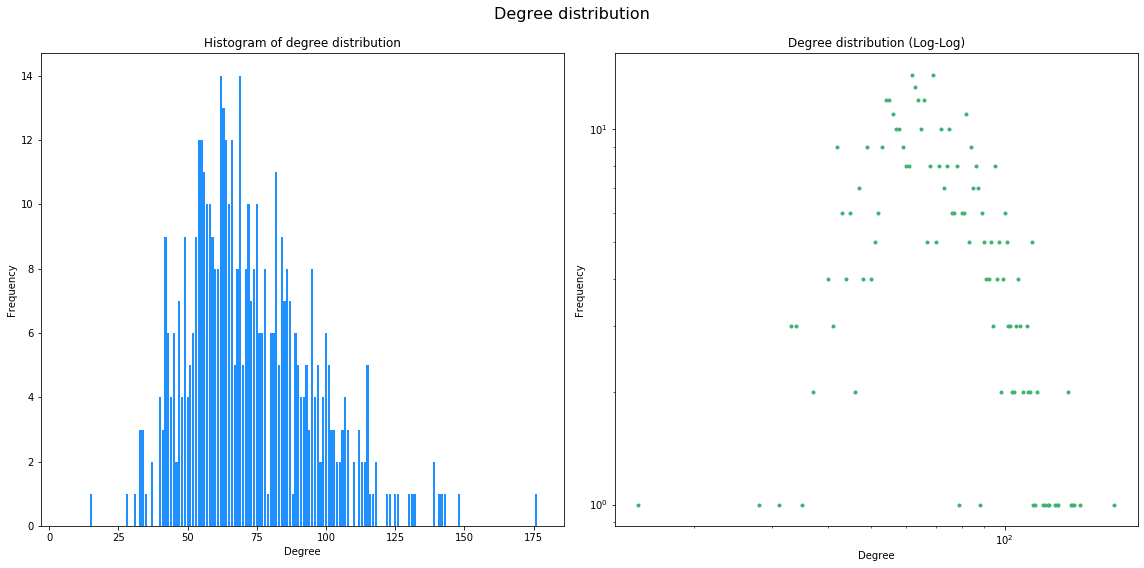

In [6]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

<b> The degree distribution </b> <br>
The degree distribution tells us the distribution of how many actors each actor is connected to. We see that it definitely does not follow a power law distribution. Rather, it looks more like a skewed normal distribution centered at around 65 <br>

<u> Thoughts on distribution </u> <br>
Recall (refer to <a href=""> this section </a>) that this network was created by extracting the <b> top </b> 500 actors from the dataset and creating a network out of that. This in turn means that all the "low" degree actors was left out on purpose. It is certainly plausible that the original network is following a power law distribution since there are a lot of actors who have only starred in 1 movie.

Let us understand the actor productivity a little better

In [84]:
'''
Create a reverse lookup: Mapping from movie -> release date
'''
reverse_movie_year_lookup={}
for i, row in df.iterrows():
    if pd.isna(row['release_date']): #movies without a release date
        continue
    reverse_movie_year_lookup[row['original_title']] = row['release_date']

'''
For each actor, look up the release date of every movie they have been in.
Store the result as a list of tuples, t = (actor, [year1, year2, ..., yearN])
'''
#Extract data
release_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    release_years_relative = [x-first_release for x in actor_movies]
    release_data.append((node, release_years_relative))
    
    
#sort the release data by most releases
release_data = sorted(release_data, key=lambda x: len(x[1]), reverse=True)

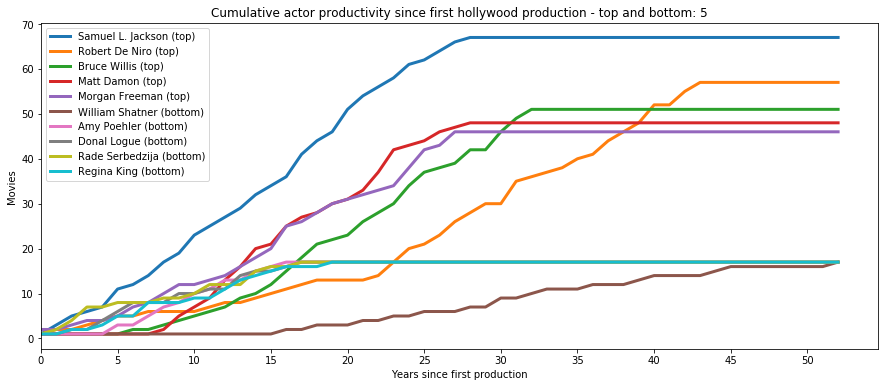

In [102]:
n = 5 #Number of actors to plot

max_ = max([max(x[1]) for x in release_data[:n] + release_data[-n:]])+1 #max years an actor has been producing


fig, ax = plt.subplots(figsize=(15, 6))

#Top actors
for actor, releases in release_data[:n]:
    x = np.arange(0, max_)
    
    unique, counts = np.unique(releases, return_counts=True)
    d = dict(zip(unique, counts))
    y = np.cumsum([d[x] if x in d.keys() else 0 for x in range(max_)])
    ax.plot(x, y, label=actor + " (top)",linewidth=3)

#Bottom actors
for actor, releases in release_data[-n:]:
    x = np.arange(0, max_)
    
    unique, counts = np.unique(releases, return_counts=True)
    d = dict(zip(unique, counts))
    y = np.cumsum([d[x] if x in d.keys() else 0 for x in range(max_)])
    ax.plot(x, y, label=actor + " (bottom)",linewidth=3)



ax.set_xlim(0)
ax.set_xticks(np.arange(0,max_, 5))
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Cumulative actor productivity since first hollywood production - top and bottom: {n}')
plt.legend(loc = 'upper left')
plt.show()

The plot of actor productivity seems to tell the story that even between **the top 500 Actors** there are quite a big diffenrence in productivity between the top and bottom. Samuel L. Jackson has produced around 20 movies pr. decade while William Shatner produces around 6 in the first 20 years

Furthermore, there seems to be a <u> trend in the productivity of the actors and actresses </u>:
* They are largely unproductive in their first five years of their career
* They are most productive between year 10 and 20 of their career
* They productivity seems to fade after around 20-25 years in the business

Now that we have a basic understanding of the network, let us try to visualize the network to get an overview

### Visual representation of the network

Let's take a look at the full network sizing the actors after productivity, coloring after most common genre, and letting opacity of edges reflect how much two actors have worked together

In [103]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [113]:
warnings.simplefilter('ignore')
def weight_color_map(weight, inverse_color=False):
    '''
    Function to weight the edges
    '''
    inv_fac=0
    if inverse_color:
        inv_fac=1
    get_tuple = lambda x: tuple(abs(inv_fac-x) for y in range(3))
    
    # Low weight edge
    if weight<2:
        
        #white
        if not inverse_color:
            (1,0,0)
        return get_tuple(0.9)
    # Mid weight edge
    elif weight <5:
        
        return get_tuple(0.6)
    # mid-high weight edge
    elif weight <7:
        # Green
        return (0.3, 0.8, 0)
    # High weight edge
    else:
        # Dark red
        return (1, 0, 0)
    
    
def plot_graph(G, actor_label_movie_limit=40, inverse_color=False):
    color_map = {}
    for genre in list(set([G.nodes[x]['top_genre'] for x in list(G.nodes)])):
        color_map[genre] = []

    for node in G.nodes:
        color_map[G.nodes[node]['top_genre']] += [node]
    fig, ax = plt.subplots(figsize=(18,16))

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5)
    
    color = {'Action': 'Red', 'Adventure': 'Blue', 'Animation': 'Pink', 'Comedy': 'Green', 'Crime': 'Brown',\
          'Drama': 'Cyan', 'Family': 'Yellow', 'Thriller' : 'White', 'Romance': 'Orange', 'Science Fiction': 'Black'}
    # Inverse
    node_label_color = 'black'
    if inverse_color:
        node_label_color='white'
    
    
    
    for key in color_map.keys():
        nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map[key],\
            node_size=[int(G.nodes[x]['movies_count'])*2 for x in color_map[key]], node_color=color[key], label=key, ax=ax)
    
    colormap_edges = [weight_color_map(G[u][v]['weight'], inverse_color) for u,v in G.edges]
    nx.draw_networkx_edges(G, positions, edge_color=colormap_edges, alpha=0.4, ax = ax,width=2)
    ax.legend(scatterpoints = 1)
    nx.draw_networkx_labels(G, positions,{y:'' if G.nodes[y]['movies_count']<actor_label_movie_limit else y for y in positions.keys()}, font_size=14, font_color=node_label_color, ax = ax)
    ax.axis('off')
    title_obj = ax.set_title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
    plt.setp(title_obj, color='white') 
    plt.setp(title_obj, fontsize=15) 

    if inverse_color:
        ax.set_facecolor('black')
        fig.set_facecolor('black')
    return ax

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.31it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


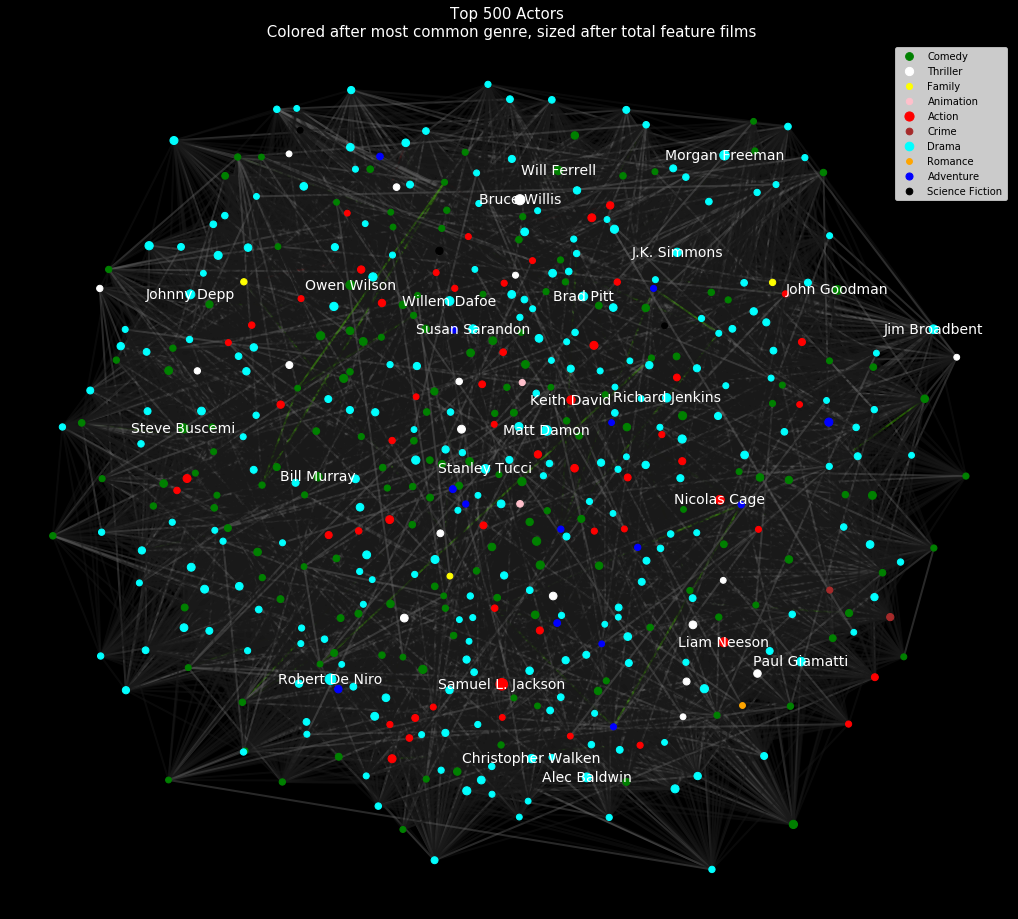

In [114]:
ax = plot_graph(G, actor_label_movie_limit=35, inverse_color=True)

plt.show()

From the above plot we see that there seem to be an overweight of actors acting within the genres of comedy, action and drama. <br> 

The high connection degree makes it difficult to see what is going on, but we see that there are definitely some central nodes in the network.

**Sig lidt mere og forbedre graf**
* Tilføj nodesize
* Find en smart måde ikke at plotte edges der er under 2 etc.

## <span style="color:red">Remove before final version</span>

### Create GIF

In [24]:
gif.options.matplotlib["dpi"] = 800

NameError: name 'gif' is not defined

In [ ]:
rand_neighbors = []

for i in range(20):
    n1 = np.random.randint(low = 20, high = 40)
    n2 = np.random.randint(low = 5, high = 8)
    n = list(G.neighbors('Samuel L. Jackson'))[n1:n1+n2] + ['Samuel L. Jackson']
    rand_neighbors += [n]

In [ ]:
%%capture
frames = []
for n in rand_neighbors:
    frame = plot_graph(G.subgraph(n))
    frames.append(frame)

In [ ]:
gif.save(frames, 'network.gif', duration=40, unit="s", between="startend")

### End GIF

## Genre

Now that we have a basic understanding of the network we can start taking a look at how the movie distribution looks across genres. In the network plot we saw a larger overweight of drama, action and comedy actors, but this was based on <u> their most common genre </u>. <br> <br> Let us try to look at the general distribution

In [116]:
#Sort by release date
df.sort_values('release_date', inplace=True)

movie_genre={}
for i, row in df.iterrows():
    movie_genre[row['original_title']]=[y['name'] for y in json.loads(row['genres'])]


genres=set([y for x in movie_genre.values() for y in x])
data = defaultdict(lambda: defaultdict(int))

for i, row in df.iterrows():
    for y in json.loads(row['genres']):
        data[row['release_date'].year][y['name']]+=1
# Set missing values
for k in data.keys():
    missing_k=genres.difference(set( x for x in data[k].keys()))
    for genre in missing_k:
        data[k][genre]=0

<span style="color:red">Skal dette med, når det kun er lokalt?</span> <br>
**Interactive plot only avaliable locally**
Below we can interact with horizontal bar plot showing genre activity across the different years.

Invesitgating for different years we see that in the early period of dataset - before 1970 - there is not a lot of datapoints. Lets plot a small movie to see how it changes from beginning to of data

In [194]:
from matplotlib.ticker import StrMethodFormatter

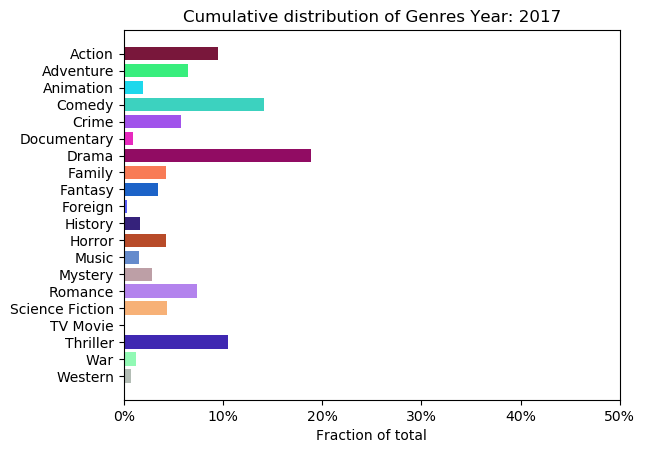

In [286]:
# Multiple plots shown as a movie
%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

fig, ax = plt.subplots()


#Cumulative plot
cumm = True

#Initial
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items(), key = lambda x: x[0], reverse = True)]

#Plot each year
cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = np.array([x[1] for x in sorted(data[year].items(), reverse = True)])
    labels_ = [x[0] for x in sorted(data[year].items(), key = lambda x: x[0], reverse = True)]
    
    cumm_data+=performance
    
    if cumm:
        performance=cumm_data
    performance = performance / performance.sum()    
    
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Fraction of total')
    plt.yticks(y_pos,labels_)
    plt.xticks([x for x in np.arange(0,11) / 10])
    plt.xlim(0,.5)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
    
    plt.title(f"Cumulative distribution of Genres Year: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

<b> Drama dominates </b> <br>
From the above plot we see that drama seems to have been the main genre since the begining of the dataset. When at its lowest, it still dominates around 20% of all the movies produced.

<b> The rise of thriller and comedy </b> <br>
From the 1990s and onwards, we see the rise in popularity of especially comedy and thrillers. This might be due to the rise of sitcoms such as Friends and Seinfield, which might also have bought the genres into the movie theaters. <br> 

To support this hypotesis, we investigate the development in genre budgets over time.

<b> Budget development </b>

In [275]:
df['year'] = df['release_date'].apply(lambda x: pd.to_datetime(x).year)

In [412]:
budgets = pd.concat(objs = [df[['budget', 'year']], df['genres'].apply(lambda x: '|'.join([y['name'] for y in json.loads(x)])).str.split('|', expand = True).fillna('')], ignore_index = True, axis = 1)
budgets = budgets.melt(id_vars = [0,1])
budgets.rename(columns = {0: 'budget', 1: 'year', 'value': 'genre'}, inplace = True)
budgets = budgets[['year', 'genre', 'budget']]

budgets = budgets[(budgets['genre'] != '') & (budgets['budget'] != 0)]
budgets['decade'] = budgets['year'].apply(lambda x: '{:.0f}s'.format(np.floor(x/10)*10))

In [444]:
g = budgets.groupby(['decade', 'genre'])['budget'].sum().unstack().fillna(0)
g = g.div(g.sum(axis=1), axis=0)

In [463]:
print()
print("Budget for genres as proportion of total")
print('----------------------------------------')
g.T.applymap(lambda x: '{:.0%}'.format(x))


Budget for genres as proportion of total
----------------------------------------


decade,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
genre,,,,,,,,,,,
Action,0%,0%,9%,1%,6%,10%,15%,16%,14%,13%,16%
Adventure,0%,0%,7%,2%,5%,7%,14%,15%,10%,12%,15%
Animation,0%,0%,3%,6%,0%,0%,0%,0%,2%,4%,5%
Comedy,0%,0%,8%,2%,6%,5%,6%,10%,10%,11%,10%
Crime,0%,0%,0%,2%,1%,3%,2%,5%,6%,5%,4%
Documentary,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
Drama,100%,50%,22%,26%,32%,24%,13%,11%,14%,12%,10%
Family,0%,0%,7%,9%,0%,4%,4%,2%,4%,7%,7%
Fantasy,0%,0%,7%,3%,0%,1%,4%,6%,5%,6%,8%


What we see above is a sharp increase in the budget of thriller and comedy movies from 1950s and onward. The proportion is decreasing a bit around the 1990s but still remains high compared to the whole period.

#### Patterns of actors work within genres

Now that the general patterns of genre has been unraveled, we can take a look how it evolves on the a selected few actors to see if we can also spot a change in the actors genre distribution pr. year around the turn of the decade.

If we see a change around this point for the two genres to becomes more popular around it would indicate that the industry is transitioning into more focus on these genres. Alternatively, it could be due to a lot of new talent emerging into the market in primarly these genres.

## <span style="color:red">Insert Asbjørns plots on actor development</span>

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones, let's take the initial steps to look if we can regonize the characteristics of the decades through the use of TF-IDF. <br>

* Do the most important words resemble the genre distribution? 
* How does it look when we relate the decade to what is happening in the world? ---- Senere ??
* Do the dominant elements from the genres correspond to what we expect?


#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to identify themes or elements of importance within pieces of text. We aim to apply this measure to movie descriptions from each decade to get an idea of the predominant subjects.


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are:

* >Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
* > Term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
* > Logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
* > Augmented frequency, to prevent a bias towards longer documents\[2\]

In our example, lengths of movie descriptions are fairly similar in length, so we use the raw count as term frequency.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the $+1$ in the denominator ensuring not division by zero and the other +1 ensuring that the domain of the function is larger than $1$

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - movie descriptions for each decade in this case 
* The collection $ C $ is the joined documents for all the movie descriptions in the  **dataset/corpus**

<b> A note on stopwods </b> <br>
Stopwords generally contribute very little to the meaning of a document. We choose to remove stopwords alltogether.

We start off by creating helperfunctions to assist in the data loading process

In [500]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    '''
    Function to load the movie descriptions for a given decade
    '''
    subset = dataf[(dataf['year'] >=  start_year) & (dataf['year'] < start_year + segment_years)]
    
    document_words = subset['overview'].apply(lambda x: np.array(str(x).split(' '))).tolist().ravel()
    collection_words = dataf['overview'].apply(lambda x: str(x).split(' ')).tolist()
    
    return document_words, collection_words
    
    
    
    return subset['overview'].apply(lambda x: x.split(' ')).tolist()
    dataf['overview'].apply(lambda x: x.split(' ')).tolist()
    
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    '''
    Function to calculate the TF-IDF measure of a given document
    Returns: A dictionary of words and their TF-IDF score
    '''
    # Naive count
    tf = Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized


In [501]:
doc, collection = load_segmented_documents(df,1970,10)

AttributeError: 'list' object has no attribute 'ravel'

In [499]:
doc

[['Set',
  'in',
  'Paris',
  'during',
  'World',
  'War',
  'I.',
  'Lili',
  'Smith/Schmidt',
  'is',
  'a',
  'German',
  'spy',
  'being',
  'requested',
  'to',
  'go',
  'under',
  'cover',
  'to',
  'help',
  'Germany',
  'during',
  'the',
  'war,',
  'to',
  'try',
  'and',
  'find',
  'out',
  'their',
  'plans.',
  'Her',
  '"uncle"',
  'wishes',
  'her',
  'to',
  'fulfill',
  'the',
  'operation,',
  'whereas',
  'one',
  'of',
  'his',
  'colleagues',
  'believed',
  'she',
  'is',
  'not',
  'capable',
  'of',
  'performing',
  'such',
  'an',
  'operation',
  'as',
  'she',
  'is',
  'British.',
  'She',
  'soon',
  'finds',
  'herself',
  'following',
  'Major',
  'William',
  "Larrabee's",
  'every',
  'move',
  'and',
  'spending',
  'all',
  'her',
  'time',
  'either',
  'with',
  'him',
  'or',
  'thinking',
  'of',
  'him.',
  'Her',
  '"uncle"',
  'realises',
  "she's",
  'in',
  'love',
  'with',
  'him',
  'but',
  'Lili',
  'is',
  'not',
  'facing',
  'that

In [89]:
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

Lets take a look at the first decade in our list and see what we find and if it relates to what we would expect for that decade

In [90]:
y=[x for x in tfidf.keys()][0]
print(f"The first decade in our data is {y}\n")
top_x=10
print(f"The top {top_x} most important words found by idf are:")
for x in [x[0] for x in sorted(tfidf[1970].items(), key=lambda x: x[1], reverse=True)[0:top_x]]:
    print(x)
top_movies=7
print(f"\nThe top {top_movies} grossing movies this decade was:")
df['decade']=df['release_date'].apply(lambda x: int(x.year/10)*10 if not pd.isna(x) else x)
print(df[df['decade']==y].sort_values('budget',ascending=False)[['original_title','budget']][0:top_movies])
print(f"\nThe top {top_movies} rated movies this decade was:")
print(df[df['decade']==y].sort_values('vote_average',ascending=False)[['original_title','vote_average']][0:top_movies])

The first decade in our data is 1970

The top 10 most important words found by idf are:
war
world
one
new
group
young
love
patton
corleone
find

The top 7 grossing movies this decade was:
                     original_title    budget
813                        Superman  55000000
1367  Star Trek: The Motion Picture  35000000
1403             The Bad News Bears  35000000
1510                           1941  35000000
1531                      Moonraker  34000000
1525                 Apocalypse Now  31500000
1877              Tora! Tora! Tora!  25485000

The top 7 rated movies this decade was:
                       original_title  vote_average
3337                    The Godfather           8.4
2731           The Godfather: Part II           8.3
3719  One Flew Over the Cuckoo's Nest           8.2
2912                        Star Wars           8.1
4337                      Taxi Driver           8.0
1525                   Apocalypse Now           8.0
3158                            Alien  

In [91]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

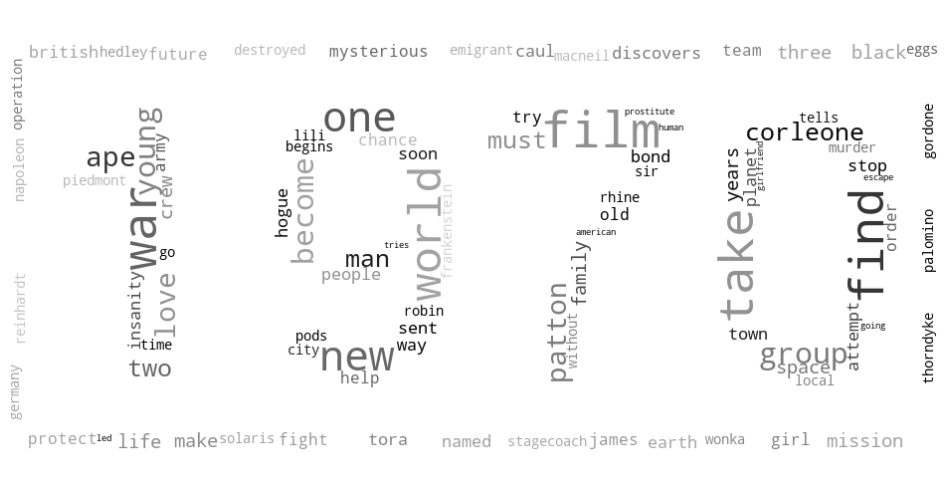

In [92]:
plot_decade_from_tfidf(1970,tfidf)

Looking at the results we find a couple of thinges that stand out. War, love, and coreleone. This make natural as important theses of the 1970's are the Anti-war movement, The gotfather movies, but can we tell if there has been a change over over the times? 

https://www.history.com/topics/1970s/1970s-1

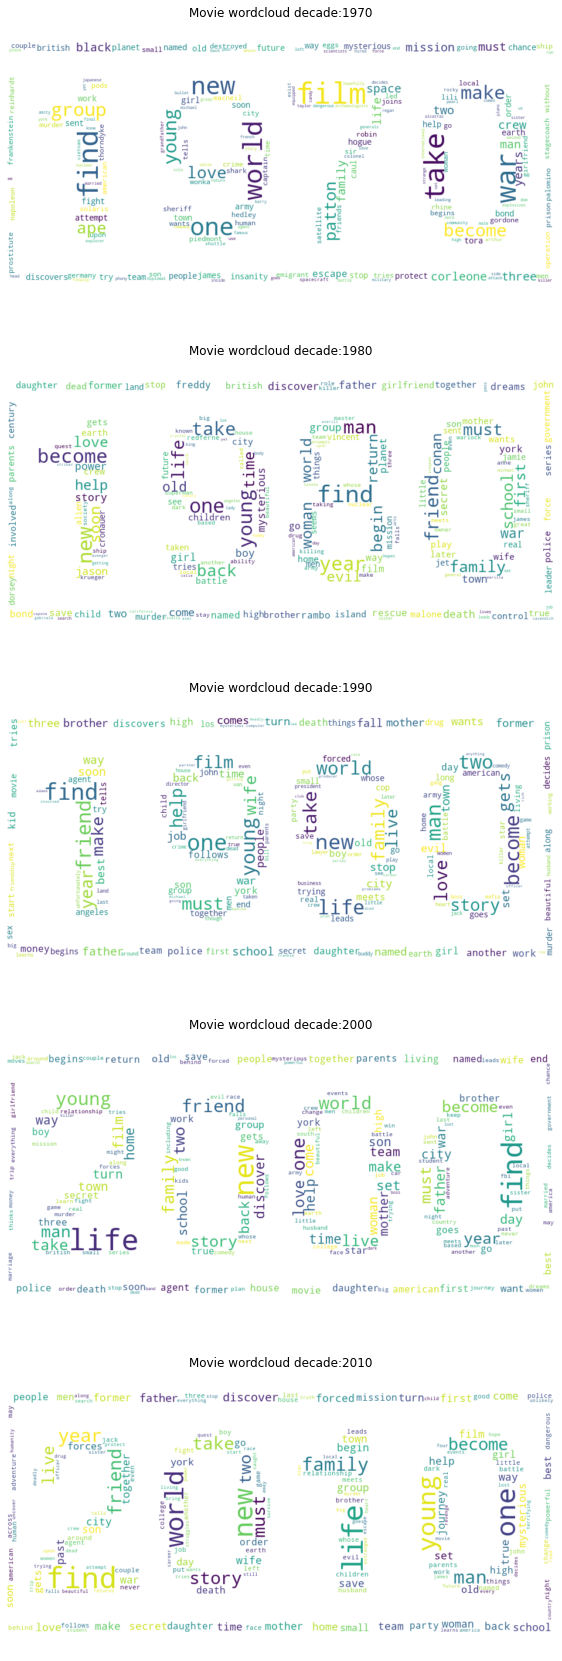

In [93]:
%matplotlib inline
nr=len(tfidf)
nc=1
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(25,30))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i in range(nr):
    year = year_keys[i]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i].imshow(wc, interpolation="bilinear")
    ax[i].set_title(f'Movie wordcloud decade:{year}')
    ax[i].axis("off")


plt.show()

In [94]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Rank,1,2,3,4,5
Decade,,,,,
1970,war,world,one,new,group
1980,new,one,young,find,man
1990,one,new,man,life,two
2000,life,new,young,one,world
2010,life,one,new,world,young


Looking at WordClouds and top words does not tell us a whole lot about the most central themes of the decades. It actuallly seems as if we are getting somewhat the same central themes across the line. This is a bit counter intuitive as the IDF term should correct this, but since we have a quite small samplesize in some of the decades without alot of uniqe words we seem to find the same results.

This indicates another weighing sceme might be better. 

### <span style="color:red">Check up on this</span>

But what about within a single genre? We earlier noticed that there was a development within the popularity of the comedy genre, can we also spot a change in the words?


In [95]:
# Get only comedy movies
df_comedy = df[df['genres'].apply(lambda x: True if not pd.isna(x) and ('Comedy' in [y['name'] for y in json.loads(x)]) else False)]
df_comedy=df_comedy.reset_index()
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df_comedy,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

In [96]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Rank,1,2,3,4,5
Decade,,,,,
1970,films,sir,hogue,one,make
1980,find,new,warlock,love,must
1990,one,new,two,life,man
2000,life,new,one,get,family
2010,life,new,one,two,friends


### <span style="color:red">COMMENTS ON DEVELOPMENT IN COMEDY GENRE</span>


### <span style="color:red">WRAP UP TF-IDF</span>


## Sentiment through the history
Now we have seen what words characterises the times through the TF-IDF analysis of the decades. Furthermore, we have gotten and idea of what happens in the world during this time compared to other decades. To dig even further in this we will now take a look at the sentiment of the words. To put it in more general terms: Can we an evolution in movie overview sentiment over times and does it change within the genres?

This will allow us later to gain a clear insight into the mood of the hollywood set and lead us to be able to answer, along with the wikipedia analysis, the question: If the world is in bad shape, do hollywood the produce more depressing/sad content?

This section we perform sentiment analysis on the movie description and relate them to the project hypotesis. To do this sentiment analysis we utilize the labMT dataset [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which is a "language assessment by Mechanical Turk (labMT) word list to score the happiness of a corpus. The labMT word list was created by combining the 5000 words most frequently appearing in four sources: Twitter, the New York Times, Google Books, and music lyrics, and then scoring the words for sentiment on Amazon’s Mechanical Turk" [\[4\]](https://buildmedia.readthedocs.org/media/pdf/labmt-simple/latest/labmt-simple.pdf)

#### Important decision about calculation 
Two important decision:

**Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to the samen word, does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

In relation to the consideration on whether to remove stop words, the course assignment 2[REF](www.githubrepo) revealed that some stop words are non-neutral, and thus the project won't remove stop words from the texts.

A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they don't say anything about the happiness of a text. Thus we remove all words with a happiness average smaller than 6 and larger than 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

Additionally preperation
* all words in the texts are set to lower case

We will start out by creating the foundation for the sentimentanalysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). And filter the data accordin to the described method above

In [97]:
path = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
#Read data
sentiment = pd.read_csv(path, skiprows = 2, sep = '\t')

In [98]:
df_s[["happiness_average", "happiness_standard_deviation"]] = sentiment[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [99]:
df_s

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
1,laughter,1,8.44,0.9723,3600,--,--,1728
2,happiness,2,8.42,1.1082,1853,2458,--,1230
3,love,3,8.30,0.9949,25,317,328,23
4,happy,4,8.26,1.1572,65,1372,1313,375
5,laughed,5,8.22,1.3746,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,death,10217,1.48,1.0150,509,307,373,433
10218,murder,10218,1.48,0.9089,2762,3110,1541,1059
10219,terrorism,10219,1.44,0.7866,--,--,3192,--
10220,rape,10220,1.30,0.8391,3133,--,4115,2977


Now that the data is loaded in, the following formula can be used to calculate the sentiment, for every decade wiki-page and the corresponding movie overview

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

This is the sum of sentiment in the text divided by the number of words. 

As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [100]:
def calculate_sentiment_dict(text_dict: dict):
    sentiment_dict = defaultdict(list)
    sentiment_dict_aggregate = {}
    words = list(df_s['word'])
    for year, text in text_dict.items():
        # Check if word in df_s if it is get happiness_average
        _temp = [(word.lower(),df_s[df_s['word']==word.lower()]['happiness_average'].values[0]) for word in text if not df_s[df_s['word']==word.lower()]['happiness_average'].empty]
        # Empty list
        if not _temp:
            continue
        sentiment_dict[year]=_temp
        dc = [x[0] for x in sentiment_dict[year]]
        word_count = nltk.FreqDist(dc).most_common()
        words = 0
        happy_score = 0
        for i in range(len(word_count)):
            words += word_count[i][1]
            happy_score += df_s['happiness_average'][df_s['word'] == word_count[i][0]].values[0]*word_count[i][1]
        v_text = happy_score/words
        sentiment_dict_aggregate[year]=v_text
    return sentiment_dict_aggregate, sentiment_dict

In [101]:
# Calculate sentiment for documents
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry and the wikipedia pages, but how do they relate to eachother and can we relate the sentiment to what we found in the word analysis?

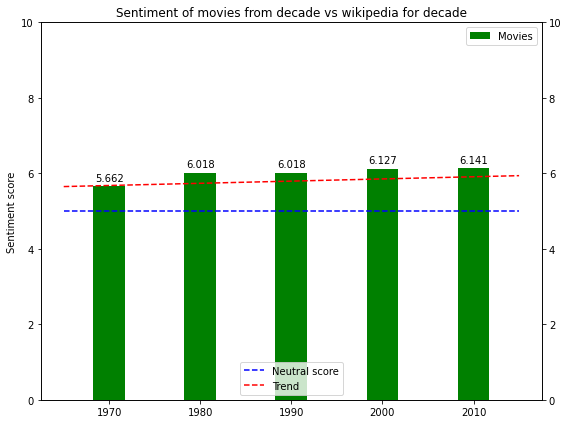

In [102]:
labels = [x[0] for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
movies = [round(x[1],3) for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
labels.reverse()
movies.reverse()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
#rects1 = ax.bar(x - width/2, wiki, width, label='Wikipedia')
rects2 = ax.bar(x, movies, width, label='Movies', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment of movies from decade vs wikipedia for decade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,10])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
autolabel(rects2)
x = np.linspace(-0.5, 4.5)
y = len(x)*[5]
z = np.linspace(5.65,5.939)
axes2 = plt.twinx()
axes2.plot(x, y, color='b', label='Neutral score',linestyle='dashed')
axes2.plot(x, z, color='r', label='Trend',linestyle='dashed')
axes2.set_ylim(0, 10)
axes2.legend(loc="lower center")
fig.tight_layout()

plt.show()

From the above plot it seems like hollywood have a slight positive sentiment, but a small upwards trend in the data. The slope coefficient is very low, but maybye this is relatable to that fact that the world is getting better. 

In a 2018 Vox posted 23 statistical measures that shows that the world is getting better such as decreasing infant mortality rate and declining hunger [\[6\]](https://www.vox.com/2014/11/24/7272929/global-poverty-health-crime-literacy-good-news) - maybe the mood in hollywood is too. 

But since the values are centered aroud a neutral is difficult to make any conclusions on the hypotesis. Combining this with the fact that we notice a fairly even distribution between genres we would also expect that the values would be centered around neutral as comedy might make up for horror. What should also be noted is that these text segments are evaluated in 2010/11, and therefore might not be very accurate for 1970 as words meaning and value change. Another element that might affect the sentiment score is that the short movie describtion simply dosen enough positive- or negatively charged words. This is what we will investigate next

I quick look at the sentiment word-list reveals that the most negatively charged words are about terrorism. The movie Zero Dark Thirty about the hunt for Osama Bin Larden, should then contain some negativly charged words.

In [103]:
print("Average overview length:", np.average([len(x) for x in df['overview'].values if type(x)==str]))


Average overview length: 305.39875


In [104]:
# Adapt to function format
zdt={'Zero Dark Thirty':tokenize(df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])}
zdt_agg, zdt_values =calculate_sentiment_dict(zdt)

print("Overview of Zero Dark Thirty :",df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])
print(f"\nZero Dark Thirty has the sentiment: {round(zdt_agg['Zero Dark Thirty'],3)}")

Overview of Zero Dark Thirty : A chronicle of the decade-long hunt for al-Qaeda terrorist leader Osama bin Laden after the September 2001 attacks, and his death at the hands of the Navy S.E.A.L. Team 6 in May, 2011.

Zero Dark Thirty has the sentiment: 4.584


Zero dark thirty has a low sentiment as expected, but how does the distribution look for all movies in the dataset?

In [ ]:
sentiment_all_movies = []
for row in df.iterrows():
    if pd.isna(row[1]['overview']):
        continue
    # Fit format
    _temp = {row[0]:tokenize(row[1]['overview'])}
    agg, val = calculate_sentiment_dict(_temp)
    if agg:
        sentiment_all_movies.append(agg)

In [ ]:
sns.displot([y for x in sentiment_all_movies for y in list(x.values())], kde=True)
plt.title('Histogram of sentiment score of movies across the dataset')
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.show()

We actually have a majority of positive movies, with a few very negative ones. Here every movies is weighted equally,  but if we want to know about the expirenced sentiment of hollywood i would make more sense to do some kind of weighing on the budget of the production, as the affect a big feature film has on someone, is probably larger than a small budget movies due to advertising and other factors favoring large productions.

### <span style="color:red">SECTION WRAP UP - missing</span>


# <span style="color:red">Actor communities</span>

## Analysis of Actor Communities and Their Sentiment

As presented in project assignment A, we have a hypotesis that there exist small communities within hollywood where groups of actors do the majority of their work together in specific genres. An example could be Denzel Washington which primarly does his work within Action and Drama. Does he always work with alot of the same crew?

To put it in general terms this section will uncover what actors work together, whether they form cliques? What charaterize these communites and a zoom in on specific Actors. 

This will be done through:
* Community detection
    * LIST DETECTION ALGORITHMS
* Important words
    * TF-IDF
    * Wordclouds
    * Lookup of movies
* Sentiment of communities
    * What communities are happy/sad?


## <span style="color:red">TEXT FROM ASSIGNMENT B</span>
### 3.1 Finding and investigating communities in the DC universe

Comunity detection is about partitioning the nodes (or edges) into an arbitrary number of groups. There are many approaches to this and in [chapter 9](http://networksciencebook.com/chapter/9#basics) of the network book, we are presented to a couple of them.

A method the book describes in detail is the Girvan-Newman algorithm. This algorithm uses hierarchical clustering that identifies high similarity clusters with a divisive algorithm procedure. The concepts are quite simple and a good starting point for the segmentation. <b> The hypothesis is that the many different stories like Batman, SuperMan, justice league etc. will have connections between eachother </b>.

Choosing the optimal segmentation from this would then be chosen by the segmentation which is optimizing the modularity.

<b> Modularity </b> <br>
Modularity is a measure of how connected a group of nodes are compared to the expectation if the network was wired randomly 

Definition from the book
>Consider a network with N nodes and L links and a partition into nc communities, each community having Nc nodes connected to each other by Lc links, where c=1,...,$n_c$. If $L_c$ is larger than the expected number of links between the $N_c$ nodes given the network’s degree sequence, then the nodes of the subgraph $C_c$ could indeed be part of a true community, as expected based on the Density Hypothesis H2 (Image 9.2). We therefore measure the difference between the network’s real wiring diagram ($A_{ij}$) and the expected number of links between $i$ and $j$ if the network is randomly wired ($p_{ij}$)

Since we are segmentating based on the maximizing the modularity, one could argue we should go for the greedy modularity algorithm instead, but since its implementation for directed graphs in netowrkx has a runtime of $n^4$, we had to go for another approach. 

The algorithm for finding the communities below uses the louvain method, which is a greedy method that runs in $O(n*log(n))$ which is a significant improvement.

This also means that our aproach is dependent on the $H4$ hypotesis: 
>For a given network the partition with maximum modularity corresponds to the optimal community structure.

We will not go into detail of the limits of modularity, but they can be found [here](http://networksciencebook.com/chapter/9#modularity) and since this implementation does not guarentee optimality, re-running the algorithm will yield different results. 

OBS:
Many of the community algorithms are only implemented for the nx.Graph class and not nx.DiGraph. <b> This is why we are working with an undirected version </b>

Related note:
Using the betweenness centrality measure and Girvan-Newman algorithm will require around 15 hour of processing time for the whole dc network

## <span style="color:red">Actor genre distribution within communities and for communities</span>

Insert data etc.

## <span style="color:red">Section wrap up</span>


Insert data etc.

# <span style="color:red">Final thoughts</span>
